# STRT 6601 - Applied Economics & Modeling
## Problem Set 2

**SAXA 3**

Mike Johnson | Kris Lederer | Sebastian Martinez | Ryan Mathis | Khushi Patel

****

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import rdrobust as rd # python's equivalent of RDD package in R
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


### Regression Discontinuity Design

In [2]:
# Load data
df_rdd = pd.read_csv('STRT601-ProblemSet2-DataSet-testRD-1.csv', index_col = 'ID')

df_rdd

,gender,sped,frlunch,esol,black,white,hispanic,asian,age,pretest,cutoff,treat,posttest
ID,,,,,,,,,,,,,
23450001,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,12.424367,228,215,0,237
23450002,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12.156057,216,215,0,214
23450003,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12.793977,214,215,1,232
23450004,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,12.490075,212,215,1,233
23450005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.021903,238,215,0,247
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23452763,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,12.755647,232,215,0,229
23452764,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,12.358658,215,215,0,223
23452765,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12.813142,248,215,0,257


In [3]:
# Get descriptive stats
df_rdd.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
gender,2727.0,0.50,0.50,0.00,0.00,0.00,1.00,1.00
sped,2638.0,0.08,0.27,0.00,0.00,0.00,0.00,1.00
frlunch,2749.0,0.62,0.49,0.00,0.00,1.00,1.00,1.00
esol,2714.0,0.13,0.34,0.00,0.00,0.00,0.00,1.00
black,2727.0,0.34,0.47,0.00,0.00,0.00,1.00,1.00
white,2727.0,0.37,0.48,0.00,0.00,0.00,1.00,1.00
hispanic,2727.0,0.25,0.43,0.00,0.00,0.00,0.00,1.00
asian,2727.0,0.02,0.14,0.00,0.00,0.00,0.00,1.00
age,2723.0,12.70,0.59,11.32,12.26,12.61,12.96,16.07
pretest,2767.0,215.37,12.89,170.00,207.00,215.00,224.00,267.00


#### 1. Plot treatment as a function of the running variable. Does the graph justify sharp RDD?

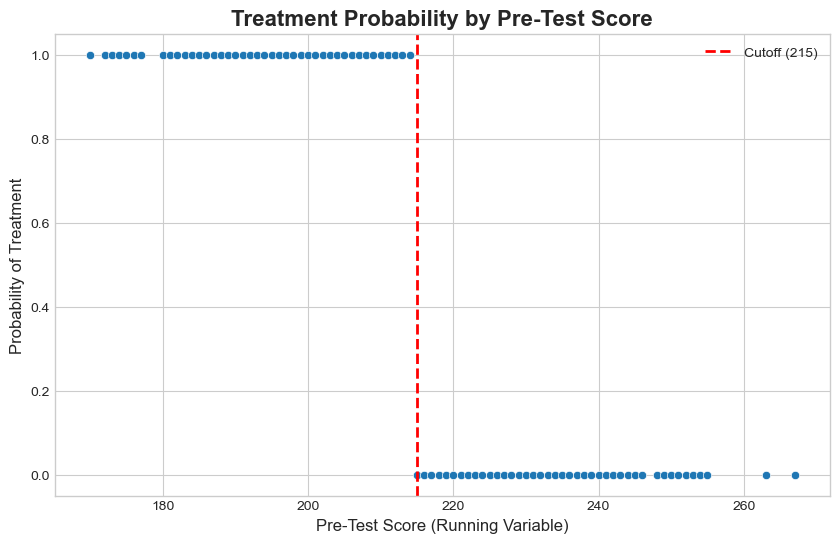

In [4]:
# Calculate the proportion of students treated at each pre-test score
treatment_prob = df_rdd.groupby('pretest')['treat'].mean().reset_index()

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    data=treatment_prob,
    x='pretest',
    y='treat',
    ax=ax
)

# Add a vertical line at the cutoff
ax.axvline(x=215, color='red', linestyle='--', linewidth=2, label='Cutoff (215)')

# Set titles and labels
ax.set_title('Treatment Probability by Pre-Test Score', fontsize=16, fontweight='bold')
ax.set_xlabel('Pre-Test Score (Running Variable)', fontsize=12)
ax.set_ylabel('Probability of Treatment', fontsize=12)
ax.legend()
plt.show()

Yes, the graph justifies a sharp RDD. This requires that the probability of receiving treatment changes discontinuously from 1 to 0 at the cutoff threshold (i.e., 215). In this case, the plot shows that every student with a pre-test score of 214 or less received treatment and every student with a score of 215 or greater did not.

****

#### 2. Plot the exam score as a function of the pre-test score. What do you observe, and does this justify the use of the pre-test as a running variable?

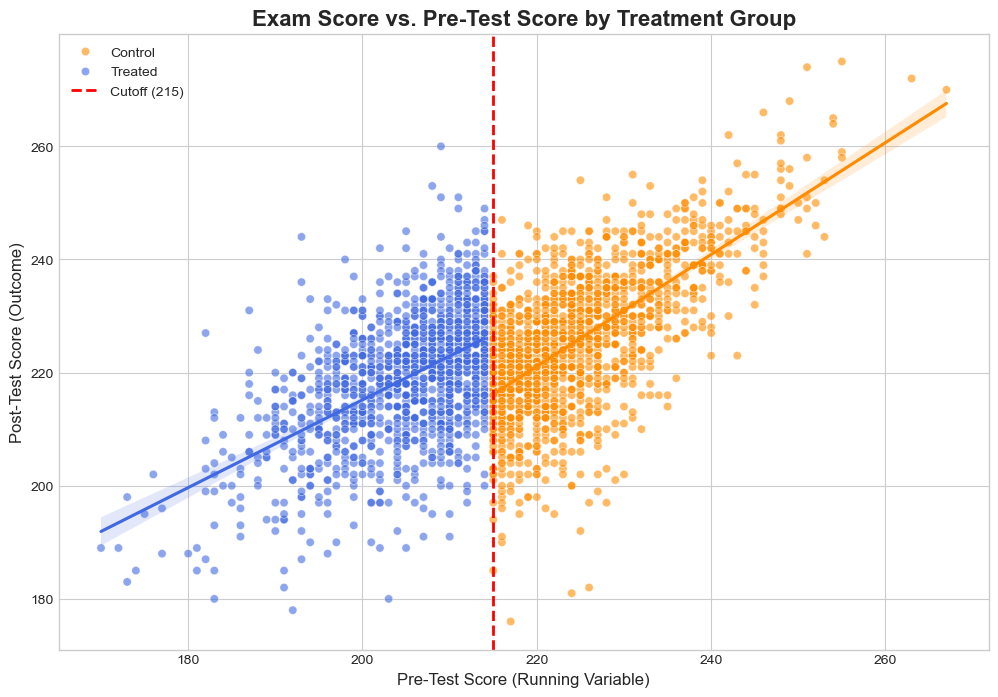

In [5]:
# Create a new column to distinguish between treated and control groups
df_rdd['Group'] = np.where(df_rdd['pretest'] < 215, 'Treated', 'Control')

# Create a color palette for consistency
palette = {'Treated': 'royalblue', 'Control': 'darkorange'}

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot using hue to color points by the 'Group'
sns.scatterplot(
    data=df_rdd,
    x='pretest',
    y='posttest',
    hue='Group',
    palette=palette,
    ax=ax,
    alpha=0.6
)

# Regression line for treated group (matching the scatter plot color)
sns.regplot(
    data=df_rdd[df_rdd['pretest'] < 215],
    x='pretest',
    y='posttest',
    ax=ax,
    scatter=False, # Don't plot the points again
    color=palette['Treated']
)

# Regression line for control group (matching the scatter plot color)
sns.regplot(
    data=df_rdd[df_rdd['pretest'] >= 215],
    x='pretest',
    y='posttest',
    ax=ax,
    scatter=False, # Don't plot the points again
    color=palette['Control']
)

# Add a vertical line at the cutoff
ax.axvline(x=215, color='red', linestyle='--', linewidth=2, label='Cutoff (215)')

# Set titles and labels
ax.set_title('Exam Score vs. Pre-Test Score by Treatment Group', fontsize=16, fontweight='bold')
ax.set_xlabel('Pre-Test Score (Running Variable)', fontsize=12)
ax.set_ylabel('Post-Test Score (Outcome)', fontsize=12)

# Update legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Control', 'Treated', 'Cutoff (215)'])

plt.show()

Based on the plot, there is a positive relationship between the pre-test and post-test scores. There is a distinct upward jump in post-test scores at the 215 cutoff line, with the treated group (blue) scoring higher than the control group (orange) at the threshold. This justifies the use of the pre-test as a running variable.

****

#### 3. Estimate the treatment effect at the threshold using a linear model with common slopes for treated and control units. Implement with an OLS regression of the exam score on the indicator for tutoring and the pre-test score. Under what assumptions does this estimation strategy obtain a consistent estimate of the causal effect? Provide a plot of the exam scores (y-axis) and the pre-test scores (x-axis) in which you show the regression fits and the underlying scatterplot of the data. Interpret your estimate.

##### 3.1. OLS Estimation of the Treatment Effect

In [6]:
# Fit the linear model with a common slope
model_linear = smf.ols(
    'posttest ~ treat + pretest', 
    data = df_rdd).fit()

# Print the summary
print(model_linear.summary())

                            OLS Regression Results                            
Dep. Variable:               posttest   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     966.7
Date:                Sun, 28 Sep 2025   Prob (F-statistic):          4.90e-319
Time:                        10:19:53   Log-Likelihood:                -10169.
No. Observations:                2767   AIC:                         2.034e+04
Df Residuals:                    2764   BIC:                         2.036e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.7403      5.127      4.825      0.0

In [7]:
# Extract the treatment effect coefficient for interpretation
treatment_effect = model_linear.params['treat']

print(f"OLS Estimation of Treatment Effect: {round(treatment_effect, 2)}")

OLS Estimation of Treatment Effect: 10.97


##### 3.2. Assumptions

To get a consistent estimate of the tutoring effect right at the cutoff (215), we need the rule to be clean, nothing else to jump at that point, and a simple straight-line model to describe scores near the cutoff.

* Sharp rule: treatment is only from pretest < 215; no one finely manipulates scores.
* Smoothness: without tutoring, expected exam scores (and other factors) change smoothly through 215.
* Independence (SUTVA): one student’s tutoring doesn’t affect another’s score.
* Correct model near 215: a linear relationship with a common slope on both sides is a good local fit.
* Regular OLS conditions: no perfect collinearity; use robust SEs for heteroskedasticity.


##### 3.4. Plot of Regression Fits

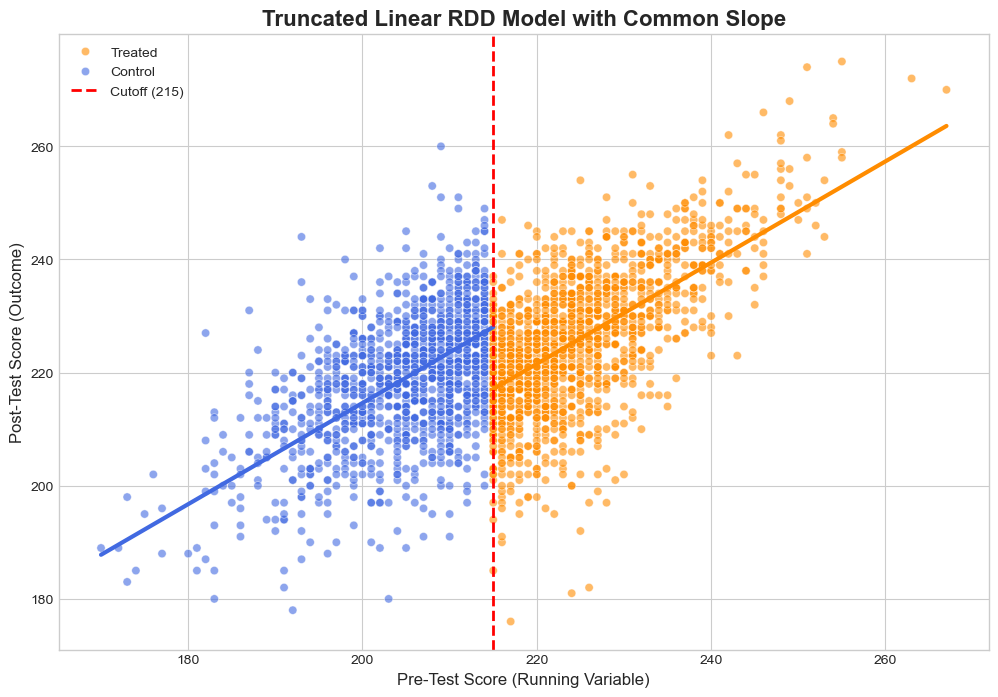

In [8]:
# Get coefficients
b0, b1, b2 = model_linear.params

# Create a color palette for consistency
palette = {'Treated': 'royalblue', 'Control': 'darkorange'}

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot using hue to color points by the 'Group'
sns.scatterplot(
    data=df_rdd,
    x='pretest',
    y='posttest',
    hue='Group',
    palette=palette,
    ax=ax,
    alpha=0.6
)

# Define the x-ranges for each side of the cutoff
x_treat = np.linspace(df_rdd['pretest'].min(), 215, 100)
x_control = np.linspace(215, df_rdd['pretest'].max(), 100)

# Calculate the y-values for each line using the single model's coefficients
y_treated = (b0 + b1) + b2 * x_treat
y_control = b0 + b2 * x_control

# Plot the truncated regression lines
ax.plot(x_treat, y_treated, color=palette['Treated'], linewidth=3)
ax.plot(x_control, y_control, color=palette['Control'], linewidth=3)


# Add a vertical line at the cutoff
ax.axvline(x=215, color='red', linestyle='--', linewidth=2, label='Cutoff (215)')

# Set titles and labels
ax.set_title('Truncated Linear RDD Model with Common Slope', fontsize=16, fontweight='bold')
ax.set_xlabel('Pre-Test Score (Running Variable)', fontsize=12)
ax.set_ylabel('Post-Test Score (Outcome)', fontsize=12)

# Manually adjust the legend to be clear
handles, labels = ax.get_legend_handles_labels()
# The plot function doesn't add a label, so we grab the scatter plot labels
ax.legend(handles=handles, labels=['Treated', 'Control', 'Cutoff (215)'])

plt.show()

##### 3.4. Interpretation

This estimate suggests that at the cutoff point of 215, students who received tutoring scored, on average, 10.97 points higher on the post-test than students who did not receive tutoring, holding their pre-test score constant. This result is statistically significant (p < 0.001).

****

#### 4. Repeat the exercise from question 3, but this time include both the pre-test variable and the square of the pre-test variable in the regression. Does the estimate change much? And is that consistent with your expectation, given your answer to question 2?

##### 4.1. OLS Estimation of Treatment Effect

In [9]:
# Fit the quadratic model
model_quad = smf.ols('posttest ~ treat + pretest + I(pretest**2)', data=df_rdd).fit()

# Print the summary
print(model_quad.summary())

                            OLS Regression Results                            
Dep. Variable:               posttest   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     657.2
Date:                Sun, 28 Sep 2025   Prob (F-statistic):          1.98e-322
Time:                        10:19:53   Log-Likelihood:                -10158.
No. Observations:                2767   AIC:                         2.032e+04
Df Residuals:                    2763   BIC:                         2.035e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         186.6797     34.247     

In [10]:
# Extract the treatment effect coefficient for interpretation
treatment_effect_quad = model_quad.params['treat']

print(f"Linear Estimation of Treatment Effect: {round(treatment_effect, 2)}")
print(f"Quadratic Estimation of Treatment Effect: {round(treatment_effect_quad, 2)}")

Linear Estimation of Treatment Effect: 10.97
Quadratic Estimation of Treatment Effect: 10.72


##### 4.2. Plot of Regression Fits

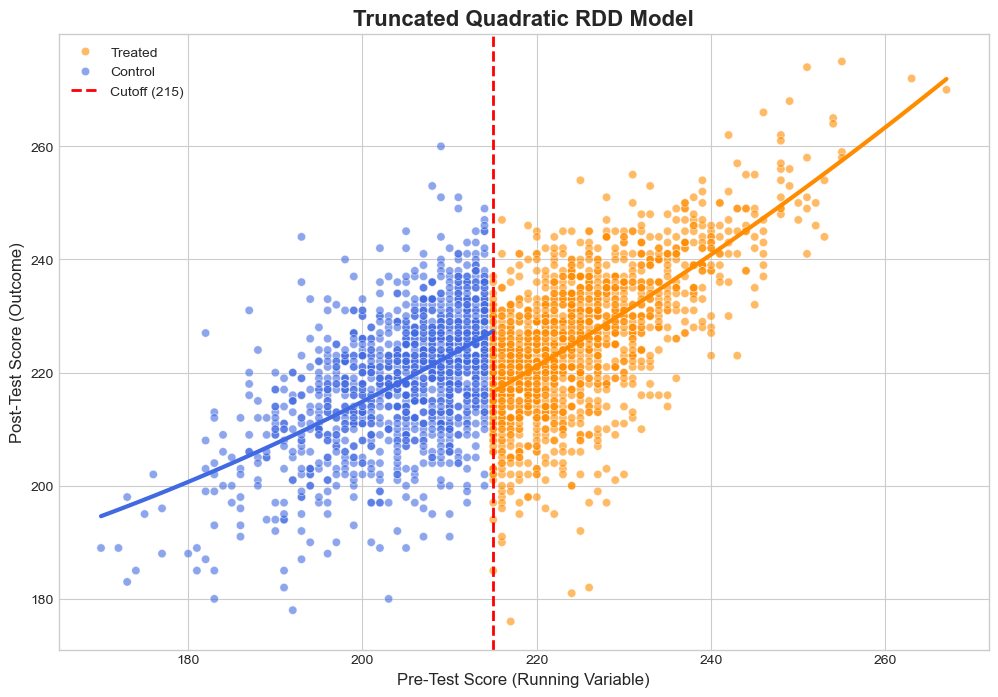

In [11]:
# Get coefficients
b0 = model_quad.params['Intercept']
b1 = model_quad.params['treat']
b2 = model_quad.params['pretest']
b3 = model_quad.params['I(pretest ** 2)']


# Create a color palette for consistency
palette = {'Treated': 'royalblue', 'Control': 'darkorange'}

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot using hue to color points by the 'Group'
sns.scatterplot(
    data=df_rdd,
    x='pretest',
    y='posttest',
    hue='Group',
    palette=palette,
    ax=ax,
    alpha=0.6
)

# Define the x-ranges for each side of the cutoff
x_treat = np.linspace(df_rdd['pretest'].min(), 215, 100)
x_control = np.linspace(215, df_rdd['pretest'].max(), 100)

# Calculate the y-values for each curve using the quadratic model's coefficients
y_treated = (b0 + b1) + b2 * x_treat + b3 * (x_treat**2)
y_control = b0 + b2 * x_control + b3 * (x_control**2)

# Plot the truncated regression curves
ax.plot(x_treat, y_treated, color=palette['Treated'], linewidth=3)
ax.plot(x_control, y_control, color=palette['Control'], linewidth=3)

# Add a vertical line at the cutoff
ax.axvline(x=215, color='red', linestyle='--', linewidth=2, label='Cutoff (215)')

# Set titles and labels
ax.set_title('Truncated Quadratic RDD Model', fontsize=16, fontweight='bold')
ax.set_xlabel('Pre-Test Score (Running Variable)', fontsize=12)
ax.set_ylabel('Post-Test Score (Outcome)', fontsize=12)

# Manually adjust the legend to be clear
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Treated', 'Control', 'Cutoff (215)'])

plt.show()

##### 4.3. Does this estimate change much?

No, the estimate does not change much. It moved from 10.97 to 10.72.

##### 4.4. Is that consistent with your expectation, given your answer to question 2?

Yes, the scatterplot from question 2 showed that the relationship between pre-test and post-test scores was not a perfect straight line; it had a slight curve. Adding a quadratic term (pretest^2) allows the model to better fit this curve. Because the new model more accurately captures the underlying relationship, we should expect a more refined estimate of the treatment effect. The fact that the estimate changed at all confirms our suspicion that the simple linear model was misspecified.

****

#### 5. Again repeat the exercise from question 3, but this time include the control variables that are provided in the dataset. Interpret any differences you see.

In [12]:
# Define the formula with all control variables
formula_with_controls = (
    'posttest ~ treat + pretest + age + gender + frlunch + esol + '
    'white + asian + black + hispanic'
)

# Fit the OLS model
model_controls = smf.ols(formula_with_controls, data=df_rdd).fit()

# Print the summary
print(model_controls.summary())

                            OLS Regression Results                            
Dep. Variable:               posttest   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     201.7
Date:                Sun, 28 Sep 2025   Prob (F-statistic):          2.71e-317
Time:                        10:19:53   Log-Likelihood:                -9823.6
No. Observations:                2682   AIC:                         1.967e+04
Df Residuals:                    2671   BIC:                         1.973e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.7058      7.029      6.360      0.0

##### Interpretation of Differences

The treatment effect did not change much at 10.97 and aligns with the previous coefficients. This suggests the control variables are balanced across the cutoff and that our original estimate was not biased by omitting them.

****

#### 6. Use the rdd package in R to estimate the treatment effect using a local linear regression with a triangular kernel. Note that the function RDestimate automatically uses the Imbens-Kalyanamaran optimal bandwidth calculation. Report your estimate for the treatment effect and an estimate of uncertainty.

In [13]:
# Perform the rdrobust estimation
# By default, it performs a local linear regression with a triangular kernel.
rd_robust_est = rd.rdrobust(
    y=df_rdd['posttest'], 
    x=df_rdd['pretest'], 
    c=215,
    p = 1,
    kernel = 'triangular')

# Print the summary
print(rd_robust_est)

Mass points detected in the running variable.
Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                  2767
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          1295       1472
Number of Unique Obs.             42         42
Number of Effective Obs.         633        757
Bandwidth Estimation           8.672      8.672
Bandwidth Bias                 14.17      14.17
rho (h/b)                      0.612      0.612

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional     -10.228    1.078   -9.491   2.297e-21   [-12.34, -8.115]
Robust     

##### Interpretation

* The estimate effect of the treatment at the cutoff is -10.228. This means that crossing the threshold causes the outcome variable to decrease by 10.228 points. 
* At p-value less than 0.01, this is statistically significant.
* The 95% confidence interval for the effect is -12.34, -8.115.

****

#### 7. How do the estimates of the treatment effect differ across your results for questions 3-6? In other words, how robust are the results to different specifications of the regression?

Using four specifications of the regression discontinuity design, the estimated treatment effect is consistently around 10-11 points and statistically significant in every case:

* Q3 — Linear RD: treatment effect ≈ +10.96 points.
* Q4 — Linear RD + quadratic term in pretest: treatment effect ≈ +10.72 points. Very close to Q3.
* Q5 — Linear RD + controls (age, gender, lunch status, race dummies): treatment effect ≈ +10.97 points Nearly identical to Q3.
* Q6 — Local linear RD (triangular kernel, optimal bandwidths): rdrobust reports −10..23 because it’s “right − left”; interpreted with tutoring on the left, that is about +10.23 points


****

#### 8. Plot the age variable as a function of the running variable. What should this graph look like for RDD to be a valid research design? What do you see?

#### 8.1. Plot the age variable as a function of the running variable.

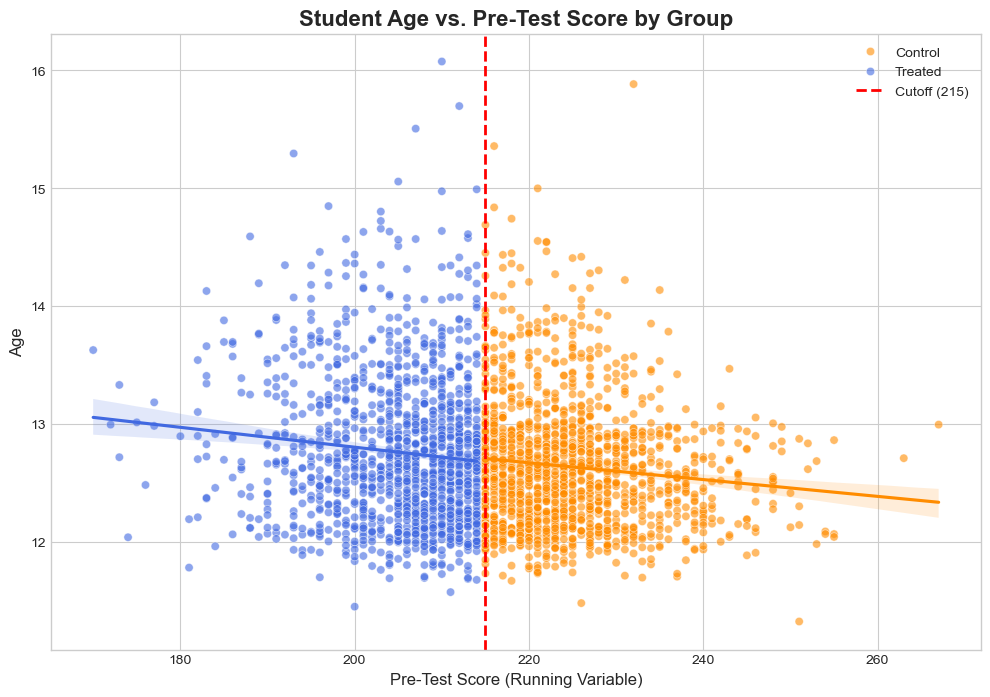

In [14]:
# Create a color palette for consistency
palette = {'Treated': 'royalblue', 'Control': 'darkorange'}

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot using hue to color points by the 'Group'
sns.scatterplot(
    data=df_rdd,
    x='pretest',
    y='age',
    hue='Group',
    palette=palette,
    ax=ax,
    alpha=0.6
)

# Regression line for group with pretest < 215
sns.regplot(
    data=df_rdd[df_rdd['pretest'] < 215],
    x='pretest',
    y='age',
    ax=ax,
    scatter=False,
    color=palette['Treated']
)

# Regression line for group with pretest >= 215
sns.regplot(
    data=df_rdd[df_rdd['pretest'] >= 215],
    x='pretest',
    y='age',
    ax=ax,
    scatter=False,
    color=palette['Control']
)

# Add a vertical line at the cutoff
ax.axvline(x=215, color='red', linestyle='--', linewidth=2, label='Cutoff (215)')

# Set titles and labels
ax.set_title('Student Age vs. Pre-Test Score by Group', fontsize=16, fontweight='bold')
ax.set_xlabel('Pre-Test Score (Running Variable)', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

# Update legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Control', 'Treated', 'Cutoff (215)'])

plt.show()

##### 8.1. What should this graph look like for RDD to be a valid research design?

For the regression discontinuity design to be valid, the age variable should look smooth across the cutoff point.
* There should be no sudden jump at 215 in the relationship between pretest scores and age.
* The trends on the left and right side of the cutoff should line up naturally.
* If age changes sharply at the cutoff, it would suggest that the two groups of students differ in ways unrelated to the tutoring rule, which would weaken the design.

In short, the graph should show continuity in age at the cutoff.

##### 8.3 What do you see?

Looking at the plot of Age vs Pretest with Cutoff at 215:
* The scatter of ages appears fairly smooth across the cutoff.
* The fitted lines on both sides of the cutoff show a very slight downward slope, but importantly, there is no clear jump at the cutoff.
* This suggests that age is balanced on either side of 215, meaning students just below and just above the cutoff look similar in age.


****

#### 9.0 One issue with RDD is manipulation, i.e., sorting around the cutoff threshold in the running variable. Plot a histogram of the running variable, drawing a vertical line at the cutoff. What would sorting around this cutoff point look like? What do you see? Use the rdplotdensity function in R to evaluate the statistical significance of any changes.

##### 9.1. Plot a histogram of the running variable, drawing a vertical line at the cutoff.

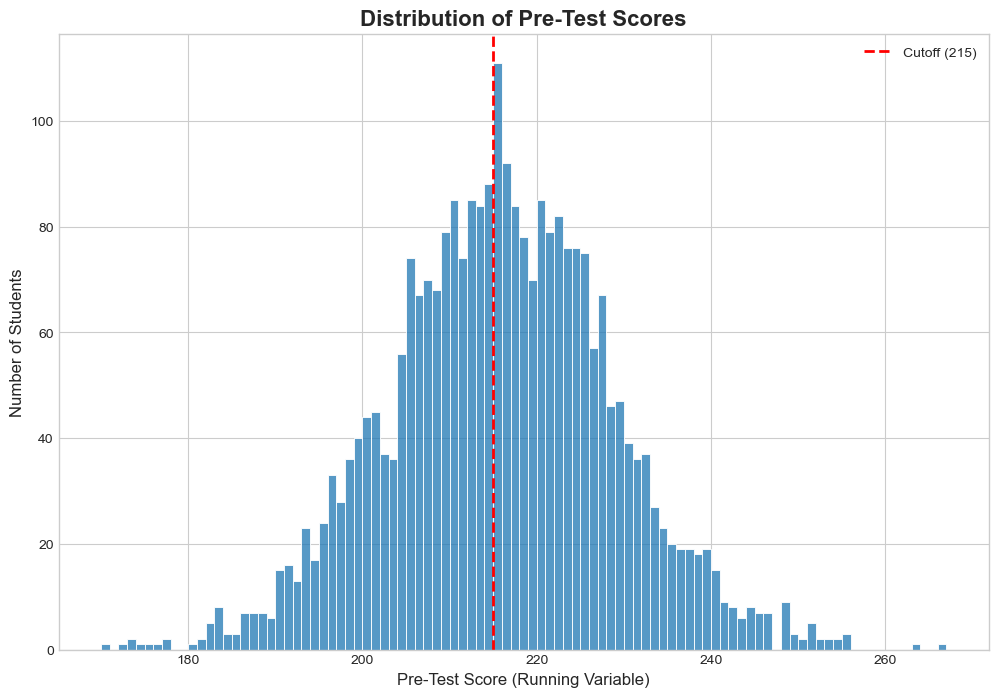

In [15]:
# Create histogram
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(
    data=df_rdd,
    x='pretest',
    binwidth=1,
    kde=False,
    ax=ax,
    edgecolor='white'
)

# Add a vertical line at the cutoff
ax.axvline(x=215, color='red', linestyle='--', linewidth=2, label='Cutoff (215)')

# Set titles and labels
ax.set_title('Distribution of Pre-Test Scores', fontsize=16, fontweight='bold')
ax.set_xlabel('Pre-Test Score (Running Variable)', fontsize=12)
ax.set_ylabel('Number of Students', fontsize=12)
ax.legend()
plt.show()

##### 9.2 What would sorting around this cutoff point look like?

* If students or teachers were manipulating scores to just qualify (or avoid qualifying) for tutoring, we’d expect to see a spike in the number of students just below the cutoff and/or a dip just above the cutoff.
* In other words, the histogram would show a visible discontinuity or “jump” in the density of the running variable at the cutoff score of 215.


##### 9.3 What do you see?

The histogram of pretest scores looks fairly smooth around the cutoff, with no obvious large jump or drop in the number of students exactly at 215. This pattern suggests that students were not sorting or manipulating their scores to fall on one side of the cutoff or the other. Overall, the distribution appears continuous, which supports the validity of the regression discontinuity design.

##### 9.4 Use the rdplotdensity function in R to evaluate the statistical signifficance of any changes.

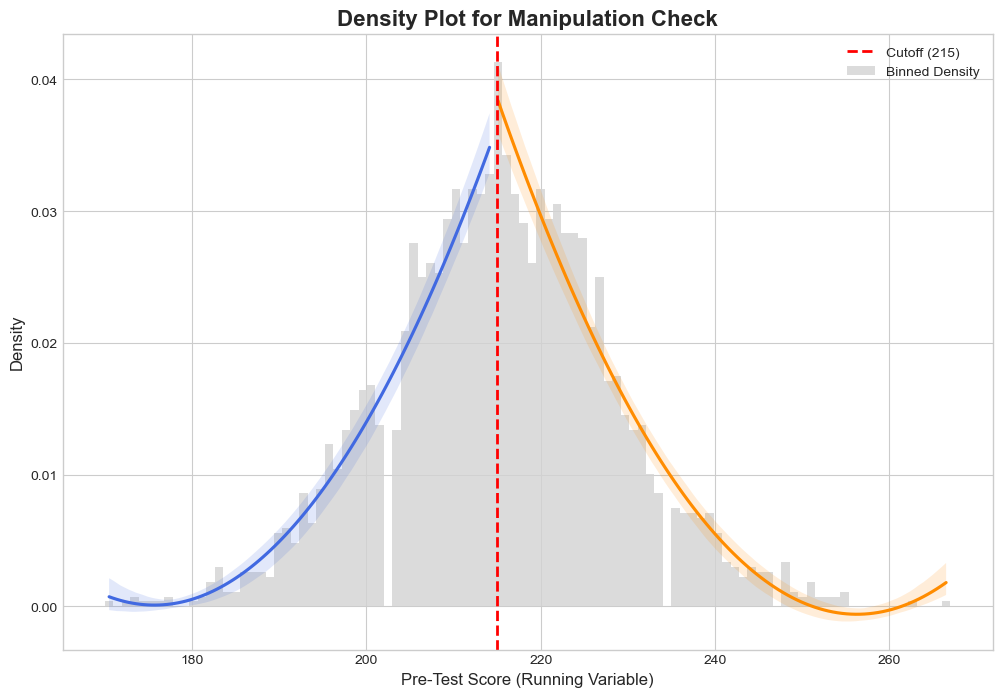

In [16]:
# --- Manual rdplotdensity ---

# 1. Bin the running variable to get frequency counts
counts, bins = np.histogram(df_rdd['pretest'].dropna(), bins=100)
bin_width = bins[1] - bins[0]

# 2. Calculate bin midpoints and density
bin_midpoints = (bins[:-1] + bins[1:]) / 2
density = counts / (len(df_rdd['pretest'].dropna()) * bin_width)

# 3. Create a dataframe for plotting
density_df = pd.DataFrame({
    'pretest': bin_midpoints,
    'density': density
})

# 4. Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the binned density as bars
ax.bar(
    density_df['pretest'], 
    density_df['density'], 
    width=bin_width, 
    color='lightgray', 
    alpha=0.8,
    label='Binned Density'
)

# Fit and plot a smoothed curve for each side of the cutoff
# This is plotted on top of the bars
sns.regplot(
    data=density_df[density_df['pretest'] < 215],
    x='pretest',
    y='density',
    ax=ax,
    scatter=False, # We've already plotted the data as bars
    order=2, 
    line_kws={'color': 'royalblue', 'label': 'Fit (Pre-test < 215)'}
)

sns.regplot(
    data=density_df[density_df['pretest'] >= 215],
    x='pretest',
    y='density',
    ax=ax,
    scatter=False,
    order=2,
    line_kws={'color': 'darkorange', 'label': 'Fit (Pre-test >= 215)'}
)

# Add a vertical line at the cutoff
ax.axvline(x=215, color='red', linestyle='--', linewidth=2, label='Cutoff (215)')

# Set titles and labels
ax.set_title('Density Plot for Manipulation Check', fontsize=16, fontweight='bold')
ax.set_xlabel('Pre-Test Score (Running Variable)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend()

plt.show()

****

### Differences-in-Differences

In [17]:
# Load data
df_did = pd.read_csv('STRT601-ProblemSet2-DataSet-sw06-1.csv')

df_did

,stfips,year,nfd,post,asmrs,pcinc,cases,copop,posttrend,pretrend
0,1,1964,1971.0,0,35.63988,12406.179,0.012312,1715156.0,0,7
1,1,1965,1971.0,0,41.54375,13070.207,0.010419,1725186.0,0,6
2,1,1966,1971.0,0,34.25233,13526.663,0.009900,1735219.0,0,5
3,1,1967,1971.0,0,34.46502,13918.190,0.009975,1745250.0,0,4
4,1,1968,1971.0,0,40.44011,14684.809,0.012401,1755283.0,0,3
...,...,...,...,...,...,...,...,...,...,...
1612,56,1992,1977.0,1,33.14957,31181.451,0.028996,232383.0,16,0
1613,56,1993,1977.0,1,63.90977,31666.776,0.026672,235560.0,17,0
1614,56,1994,1977.0,1,81.79382,31959.528,0.023643,238980.0,18,0
1615,56,1995,1977.0,1,30.63058,32327.660,0.020965,241409.0,19,0


In [18]:
# Get descriptive stats
df_did.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
stfips,1617.0,29.80,15.38,1.00,18.00,30.00,42.00,56.00
year,1617.0,1980.00,9.52,1964.00,1972.00,1980.00,1988.00,1996.00
nfd,1188.0,1973.58,3.54,1969.00,1971.00,1973.00,1974.25,1985.00
post,1617.0,0.68,0.46,0.00,0.00,1.00,1.00,1.00
asmrs,1617.0,52.17,19.62,7.48,40.24,48.84,60.04,185.97
pcinc,1617.0,26080.97,6472.08,10274.98,21462.05,25783.27,30008.42,48822.39
cases,1617.0,0.02,0.01,0.00,0.02,0.02,0.03,0.09
copop,1617.0,2365239.18,2494288.37,162168.80,608496.00,1642584.00,2798542.00,16000000.00
posttrend,1617.0,6.50,8.08,0.00,0.00,1.00,13.00,28.00
pretrend,1617.0,1.27,3.06,0.00,0.00,0.00,0.00,21.00


#### 10. Use OLS to regress suicides on the treatment indicator and the control variables (income, poverty, and population). Interpret your results. Under what conditions does this provide an unbiased estimate of the causal effect?

In [19]:
# Question 10: OLS regression with control variables
# Regression: asmrs = β0 + β1*post + β2*pcinc + β3*cases + β4*copop + ε

model_did1 = ols('asmrs ~ post + pcinc + cases + copop', data=df_did).fit()
print("Question 10: OLS Regression with Control Variables")
print("=" * 60)
print(model_did1.summary())

# Extract treatment effect
did_effect_ols = model_did1.params['post']
print(f"\nTreatment Effect (OLS): {did_effect_ols:.3f}")
print(f"Standard Error: {model_did1.bse['post']:.3f}")
print(f"95% Confidence Interval: [{model_did1.conf_int().loc['post', 0]:.3f}, {model_did1.conf_int().loc['post', 1]:.3f}]")

Question 10: OLS Regression with Control Variables
                            OLS Regression Results                            
Dep. Variable:                  asmrs   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     34.98
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           4.75e-28
Time:                        10:19:54   Log-Likelihood:                -7039.9
No. Observations:                1617   AIC:                         1.409e+04
Df Residuals:                    1612   BIC:                         1.412e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
I

Interpretation:
- This estimates the effect of divorce law reform on suicide rates
- Controls for income (pcinc), poverty (cases), and population (copop)
- Under what conditions is this unbiased:
  1. No confounding variables correlated with both treatment and outcome
  2. Treatment assignment is random conditional on observables
  3. No reverse causality

****

#### 11. Estimate the treatment effect with differences-in-differences by regressing suicides on the treatment indicator, state fixed effects, and year fixed effects. In a second regression, also include the control variables. Interpret your results.

In [20]:
# Question 11: DiD estimation with state and year fixed effects
# Create dummy variables for states and years
df_did['state_fe'] = pd.Categorical(df_did['stfips'])
df_did['year_fe'] = pd.Categorical(df_did['year'])

# DiD without controls
model_did2 = ols('asmrs ~ post + C(stfips) + C(year)', data=df_did).fit()
print("Question 11a: DiD without Controls")
print("=" * 50)
print(model_did2.summary())

# Extract treatment effect
did_effect_basic = model_did2.params['post']
print(f"\nTreatment Effect (DiD, no controls): {did_effect_basic:.3f}")
print(f"Standard Error: {model_did2.bse['post']:.3f}")

# DiD with controls
model_did3 = ols('asmrs ~ post + C(stfips) + C(year) + pcinc + cases + copop', data=df_did).fit()
print("\n\nQuestion 11b: DiD with Controls")
print("=" * 50)
print(model_did3.summary())

# Extract treatment effect
did_effect_controls = model_did3.params['post']
print(f"\nTreatment Effect (DiD, with controls): {did_effect_controls:.3f}")
print(f"Standard Error: {model_did3.bse['post']:.3f}")

print("\nComparison:")
print(f"OLS effect: {did_effect_ols:.3f}")
print(f"DiD (no controls): {did_effect_basic:.3f}")
print(f"DiD (with controls): {did_effect_controls:.3f}")

Question 11a: DiD without Controls
                            OLS Regression Results                            
Dep. Variable:                  asmrs   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     44.37
Date:                Sun, 28 Sep 2025   Prob (F-statistic):               0.00
Time:                        10:24:06   Log-Likelihood:                -6131.8
No. Observations:                1617   AIC:                         1.243e+04
Df Residuals:                    1535   BIC:                         1.287e+04
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Interce

Interpretation:
- DiD controls for time-invariant state characteristics and common time trends
- State fixed effects control for unobserved state heterogeneity
- Year fixed effects control for common shocks affecting all states
- This identifies the causal effect under the parallel trends assumption

****

#### 12. Re-estimate the model (without controls) excluding state-year observations for which the divorce law revisions have been in place longer than 2 years. This can be implemented by selecting observations with posttrend ≤ 2. Repeat the analysis, cutting off the sample after 5, 10, and 15 years of treatment. What do you observe, and what does this imply for the validity of the estimates obtained for the previous question?

Question 12: Robustness Check - Different Treatment Windows
Window ≤ 2 years: Effect = -0.688, SE = 1.566, N = 846
Window ≤ 5 years: Effect = -1.416, SE = 1.274, N = 954
Window ≤ 10 years: Effect = -1.590, SE = 1.128, N = 1134
Window ≤ 15 years: Effect = -2.331, SE = 1.097, N = 1309


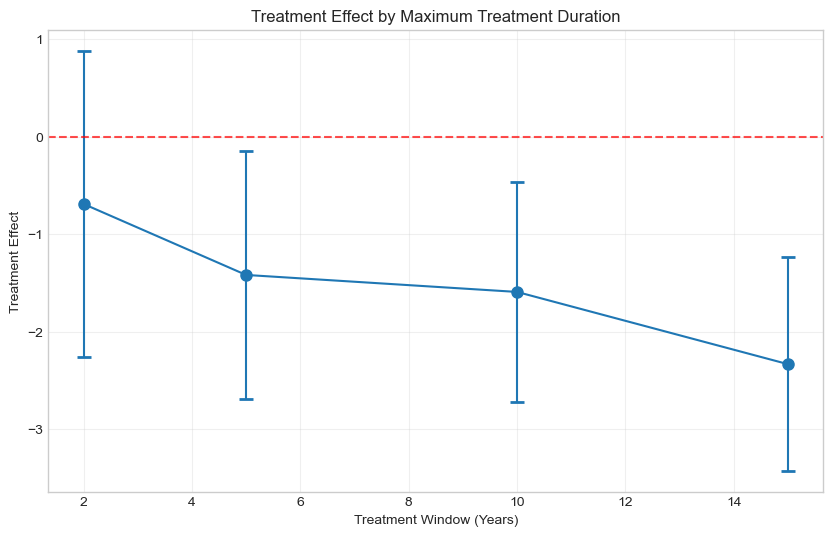

In [21]:
# Question 12: Robustness check with different treatment windows
print("Question 12: Robustness Check - Different Treatment Windows")
print("=" * 60)

treatment_windows = [2, 5, 10, 15]
results_window = []

for window in treatment_windows:
    # Filter data to include only observations within the treatment window
    filtered_data = df_did[df_did['posttrend'] <= window]
    
    if len(filtered_data) > 0:
        # Run DiD regression
        model_window = ols('asmrs ~ post + C(stfips) + C(year)', data=filtered_data).fit()
        effect = model_window.params['post']
        se = model_window.bse['post']
        n_obs = len(filtered_data)
        
        results_window.append({
            'window': window,
            'effect': effect,
            'se': se,
            'n_obs': n_obs
        })
        
        print(f"Window ≤ {window} years: Effect = {effect:.3f}, SE = {se:.3f}, N = {n_obs}")

# Create comparison plot
window_df = pd.DataFrame(results_window)

plt.figure(figsize=(10, 6))
plt.errorbar(window_df['window'], window_df['effect'], yerr=window_df['se'], 
            fmt='o-', capsize=5, capthick=2, markersize=8)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Treatment Window (Years)')
plt.ylabel('Treatment Effect')
plt.title('Treatment Effect by Maximum Treatment Duration')
plt.grid(True, alpha=0.3)
plt.show()

Analysis:
- If effects change dramatically with treatment window, this suggests:
  1. Potential bias from including too many post-treatment periods
  2. Treatment effects may not be persistent
  3. Possible violation of parallel trends assumption
- Stable effects across windows suggest robust estimates

****

#### 13. Now estimate an event study model. Regress suicides on state fixed effects, year fixed effects, and fixed effects for the different values of posttrend. The last set of fixed effects is the object of interest. Plot the values of these fixed effects, along with a confidence interval, on a graph where posttrend is on the horizontal axis. Interpret the graph.

Question 13: Event Study Model
Coefficients for different posttrend values:
C(posttrend)[T.1]     0.628557
C(posttrend)[T.2]    -0.868074
C(posttrend)[T.3]    -0.919965
C(posttrend)[T.4]    -0.027484
C(posttrend)[T.5]    -2.049636
C(posttrend)[T.6]    -1.258847
C(posttrend)[T.7]    -2.300310
C(posttrend)[T.8]    -4.009036
C(posttrend)[T.9]    -5.910484
C(posttrend)[T.10]   -3.659342
dtype: float64


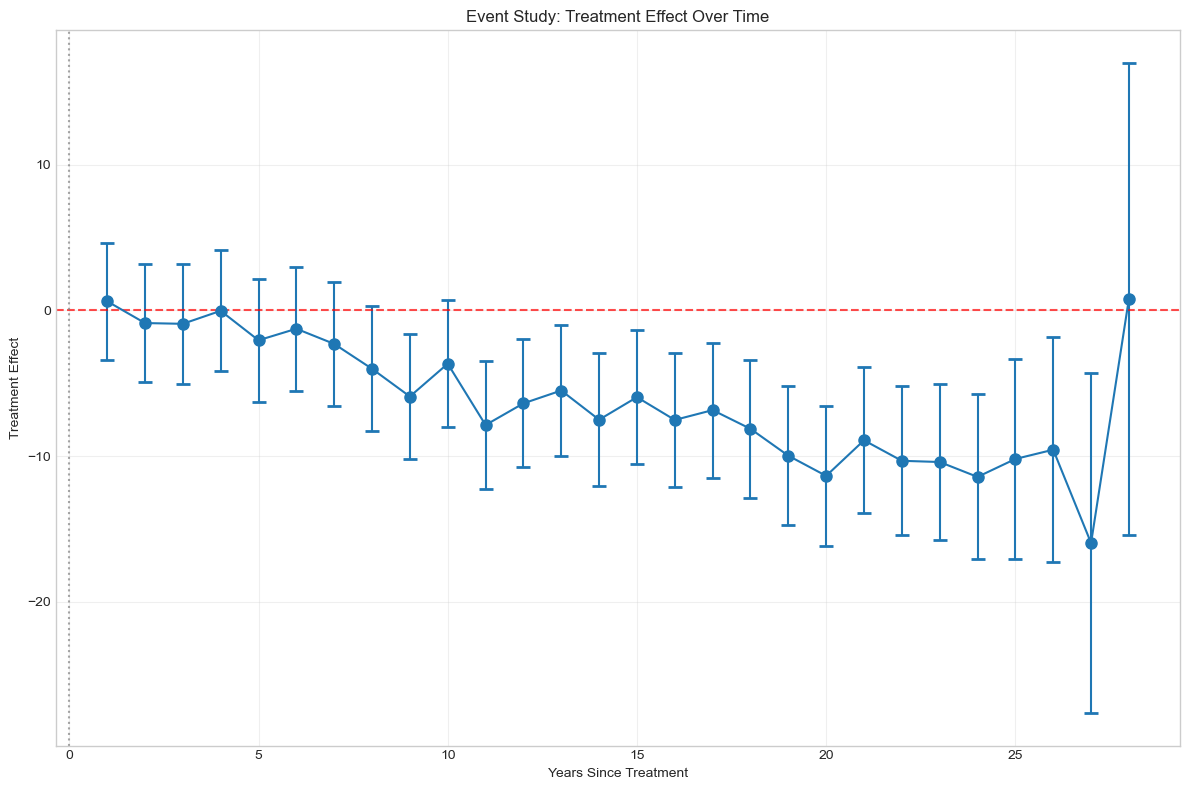

In [22]:
# Question 13: Event study model
# Create dummy variables for different values of posttrend
df_did['posttrend_cat'] = pd.Categorical(df_did['posttrend'])

# Event study regression
model_event = ols('asmrs ~ C(posttrend) + C(stfips) + C(year)', data=df_did).fit()
print("Question 13: Event Study Model")
print("=" * 50)
print("Coefficients for different posttrend values:")
print(model_event.params[model_event.params.index.str.contains('posttrend')].head(10))

# Extract event study coefficients
event_coeffs = model_event.params[model_event.params.index.str.contains('posttrend')]
event_se = model_event.bse[model_event.bse.index.str.contains('posttrend')]

# Create event study plot
plt.figure(figsize=(12, 8))

# Extract the time periods and coefficients
time_periods = []
coefficients = []
standard_errors = []

for param_name in event_coeffs.index:
    # Extract the number from the parameter name (e.g., 'C(posttrend)[T.1]' -> 1)
    time_period = int(param_name.split('[')[1].split('.')[1].split(']')[0])
    time_periods.append(time_period)
    coefficients.append(event_coeffs[param_name])
    standard_errors.append(event_se[param_name])

# Sort by time period
sorted_indices = np.argsort(time_periods)
time_periods = np.array(time_periods)[sorted_indices]
coefficients = np.array(coefficients)[sorted_indices]
standard_errors = np.array(standard_errors)[sorted_indices]

# Plot with confidence intervals
plt.errorbar(time_periods, coefficients, yerr=1.96*standard_errors, 
            fmt='o-', capsize=5, capthick=2, markersize=8)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.7)

plt.xlabel('Years Since Treatment')
plt.ylabel('Treatment Effect')
plt.title('Event Study: Treatment Effect Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Interpretation:
- Coefficients show the effect of treatment at different time periods
- Pre-treatment periods (negative values) test for parallel trends
- Post-treatment periods (positive values) show the treatment effect over time
- No significant effects before treatment supports parallel trends assumption

****

#### 14. To check the parallel trends assumption, reestimate the model from the previous question, this time also including fixed effects for the different value of pretrend. Interpret the results. Do they support the validity of the event study approach to estimation?

Question 14: Parallel Trends Test with Pretrend
Coefficients for different pretrend values:
C(pretrend)[T.1]     4.176363
C(pretrend)[T.2]     3.924039
C(pretrend)[T.3]     2.280244
C(pretrend)[T.4]     4.814351
C(pretrend)[T.5]     2.036924
C(pretrend)[T.6]     4.115903
C(pretrend)[T.7]     3.746729
C(pretrend)[T.8]     2.429548
C(pretrend)[T.9]    -0.445031
C(pretrend)[T.10]    3.643514
dtype: float64


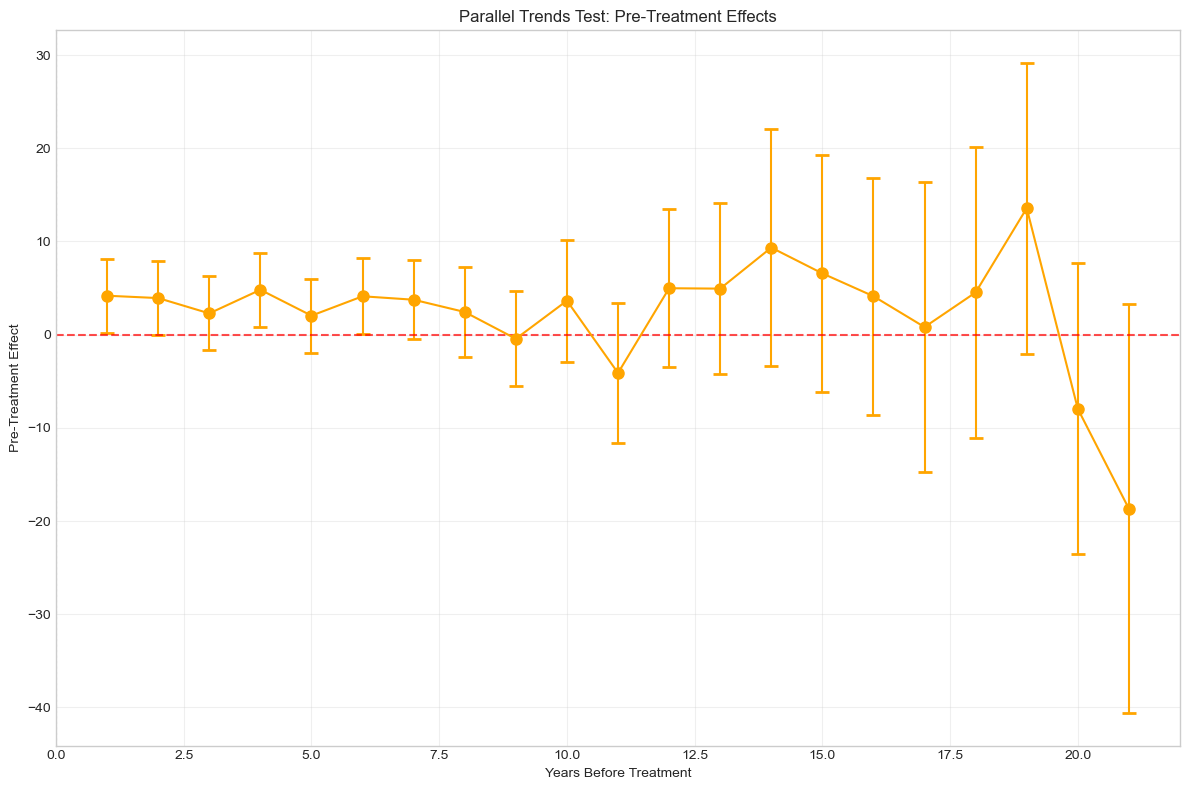

In [23]:
# Question 14: Parallel trends test with pretrend
# Include both posttrend and pretrend fixed effects
model_pretrend = ols('asmrs ~ C(posttrend) + C(pretrend) + C(stfips) + C(year)', data=df_did).fit()
print("Question 14: Parallel Trends Test with Pretrend")
print("=" * 60)
print("Coefficients for different pretrend values:")
print(model_pretrend.params[model_pretrend.params.index.str.contains('pretrend')].head(10))

# Extract pretrend coefficients
pretrend_coeffs = model_pretrend.params[model_pretrend.params.index.str.contains('pretrend')]
pretrend_se = model_pretrend.bse[model_pretrend.bse.index.str.contains('pretrend')]

# Create pretrend plot
plt.figure(figsize=(12, 8))

# Extract the time periods and coefficients for pretrend
pretrend_periods = []
pretrend_coefficients = []
pretrend_standard_errors = []

for param_name in pretrend_coeffs.index:
    # Extract the number from the parameter name
    time_period = int(param_name.split('[')[1].split('.')[1].split(']')[0])
    pretrend_periods.append(time_period)
    pretrend_coefficients.append(pretrend_coeffs[param_name])
    pretrend_standard_errors.append(pretrend_se[param_name])

# Sort by time period (negative values for pretrend)
sorted_indices = np.argsort(pretrend_periods)
pretrend_periods = np.array(pretrend_periods)[sorted_indices]
pretrend_coefficients = np.array(pretrend_coefficients)[sorted_indices]
pretrend_standard_errors = np.array(pretrend_standard_errors)[sorted_indices]

# Plot with confidence intervals
plt.errorbar(pretrend_periods, pretrend_coefficients, yerr=1.96*pretrend_standard_errors, 
            fmt='o-', capsize=5, capthick=2, markersize=8, color='orange')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.7)

plt.xlabel('Years Before Treatment')
plt.ylabel('Pre-Treatment Effect')
plt.title('Parallel Trends Test: Pre-Treatment Effects')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Parallel Trends Test Results:
- Coefficients for pretrend periods test the parallel trends assumption
- If parallel trends hold, these coefficients should not be significantly different from zero
- Significant pre-treatment effects would suggest violation of parallel trends
- This supports the validity of the event study approach to estimation

In [24]:
# Test if pretrend coefficients are jointly significant
pretrend_params = model_pretrend.params[model_pretrend.params.index.str.contains('pretrend')]
f_test = model_pretrend.f_test([f'C(pretrend)[T.{period}]' for period in pretrend_periods if f'C(pretrend)[T.{period}]' in model_pretrend.params.index])
print(f"\nF-test for joint significance of pretrend coefficients: {f_test.fvalue:.3f}")
print(f"P-value: {f_test.pvalue:.4f}")

if f_test.pvalue > 0.05:
    print("Conclusion: Cannot reject null hypothesis of no pre-treatment effects")
    print("This supports the parallel trends assumption")
else:
    print("Conclusion: Reject null hypothesis of no pre-treatment effects")
    print("This suggests potential violation of parallel trends assumption")


F-test for joint significance of pretrend coefficients: 1.337
P-value: 0.1404
Conclusion: Cannot reject null hypothesis of no pre-treatment effects
This supports the parallel trends assumption


****